#**Inception**

In [ ]:
#upload the kaggle json
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!kaggle datasets download -d muntakimrafi/bengali-sign-language-dataset

100% 187M/188M [00:09<00:00, 24.6MB/s]
100% 188M/188M [00:09<00:00, 20.7MB/s]


In [ ]:
# unzip the file
import zipfile
zip_ref = zipfile.ZipFile('/content/bengali-sign-language-dataset.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

In [ ]:
import keras
from PIL import Image
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import cv2
from sklearn.utils import shuffle
import tensorflow as tf
import os
import numpy as np
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

In [ ]:
import os
import cv2
import numpy as np

# Define your functions

def enhance_sharpness(image, alpha=2.5, beta=-1.5, kernel_size=(5, 5)):
    blurred = cv2.GaussianBlur(image, kernel_size, 0)
    return cv2.addWeighted(image, alpha, blurred, beta, 0)

def remove_noise(image, kernel_size=(5, 5)):
    blurred = cv2.GaussianBlur(image, kernel_size, 0)
    return blurred

def resizing_image(image, width, height):
    resized_image = cv2.resize(image, (width, height))
    return resized_image

def modified_image(image_path):
    image = cv2.imread(image_path)
    resized_image = resizing_image(image, 150, 150)
    denoised_image = remove_noise(resized_image)
    sharpness_image = enhance_sharpness(denoised_image)
    return sharpness_image

In [ ]:
main_folder_path = "/content/RESIZED_DATASET"

data = []
labels = []


for folder_name in os.listdir(main_folder_path):
    folder_path = os.path.join(main_folder_path, folder_name)

    # Check if the path is a directory
    if os.path.isdir(folder_path):
        # Traverse each image in the folder
        for image_name in tqdm(os.listdir(folder_path), desc=folder_name):
            image_path = os.path.join(folder_path, image_name)

            # Process the image
            image = modified_image(image_path)

            # Append the image to the data list
            data.append(image)

            # Append the label (folder name) to the labels list
            labels.append(folder_name)

# Convert lists to numpy arrays for further processing if needed
data = np.array(data)
labels = np.array(labels)


11: 100%|██████████| 291/291 [00:00<00:00, 756.93it/s]


In [ ]:
main_folder_path = "/content/RESIZED_TESTING_DATA"

dataTest = []
labelsTest = []


for folder_name in os.listdir(main_folder_path):
    folder_path = os.path.join(main_folder_path, folder_name)

    # Check if the path is a directory
    if os.path.isdir(folder_path):
        # Traverse each image in the folder
        for image_name in tqdm(os.listdir(folder_path), desc=folder_name):
            image_path = os.path.join(folder_path, image_name)

            # Process the image
            image = modified_image(image_path)

            # Append the image to the data list
            dataTest.append(image)

            # Append the label (folder name) to the labels list
            labelsTest.append(folder_name)

# Convert lists to numpy arrays for further processing if needed
dataTest = np.array(dataTest)
labelsTest = np.array(labelsTest)


11: 100%|██████████| 40/40 [00:00<00:00, 547.24it/s]


In [ ]:
print('Training Data: ',len(data))
print('Training Label: ',len(labels))
print('Testing Data: ',len(dataTest))
print('Testing Label: ',len(labelsTest))

Training Data:  11061
Training Label:  11061
Testing Data:  1520
Testing Label:  1520


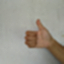

In [ ]:
cv2_imshow(data[0])

In [ ]:
label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(labels)
labelsTest = label_encoder.fit_transform(labelsTest)
X_train = (data)
y_train = (labels)
X_test = (dataTest)
y_test = (labelsTest)

In [ ]:
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder()
y_train = encoder.fit_transform(y_train.reshape(-1, 1)).toarray()
y_test = encoder.fit_transform(y_test.reshape(-1, 1)).toarray()

### **Acc 90**

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.applications import InceptionV3

# Load the InceptionV3 model pretrained on ImageNet
model = InceptionV3(weights='imagenet', input_shape=(150, 150, 3), include_top=False)

# Display model summary
model.summary()

# Flatten the output of the last convolutional layer
flat1 = Flatten()(model.layers[-1].output)

# Add Dense layers for classification
class1 = Dense(1024, activation='relu')(flat1)
class2 = Dense(512, activation='relu')(class1)
class3 = Dense(256, activation='relu')(class2)
class4 = Dense(128, activation='relu')(class3)

# Output layer with softmax activation for 38 classes
output = Dense(38, activation='softmax')(class4)

# Define new model
model = Model(inputs=model.inputs, outputs=output)

# Display model summary
model.summary()

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Define a callback to save the model with the highest validation accuracy
checkpoint = ModelCheckpoint('best_models.h5', monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 150, 150, 3)]        0         []                            
                                                                                                  
 conv2d_188 (Conv2D)         (None, 74, 74, 32)           864       ['input_3[0][0]']             
                                                                                                  
 batch_normalization_188 (B  (None, 74, 74, 32)           96        ['conv2d_188[0][0]']          
 atchNormalization)                                                                               
                                                                                                  
 activation_188 (Activation  (None, 74, 74, 32)           0         ['batch_normalizati

In [ ]:
history = model.fit(
    X_train,y_train,batch_size=64,
    validation_data=(X_test, y_test),
    epochs=20,
    callbacks=[checkpoint]
)

Epoch 1/20
173/173 [==============================] - ETA: 0s - loss: 3.2867 - accuracy: 0.0975
Epoch 1: val_accuracy improved from -inf to 0.04079, saving model to best_models.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


173/173 [==============================] - 72s 248ms/step - loss: 3.2867 - accuracy: 0.0975 - val_loss: 11.0322 - val_accuracy: 0.0408
Epoch 2/20
173/173 [==============================] - ETA: 0s - loss: 1.5776 - accuracy: 0.4856
Epoch 2: val_accuracy improved from 0.04079 to 0.48947, saving model to best_models.h5
173/173 [==============================] - 42s 242ms/step - loss: 1.5776 - accuracy: 0.4856 - val_loss: 2.7624 - val_accuracy: 0.4895
Epoch 3/20
173/173 [==============================] - ETA: 0s - loss: 0.7890 - accuracy: 0.7495
Epoch 3: val_accuracy improved from 0.48947 to 0.60132, saving model to best_models.h5
173/173 [==============================] - 40s 229ms/step - loss: 0.7890 - accuracy: 0.7495 - val_loss: 1.4320 - val_accuracy: 0.6013
Epoch 4/20
173/173 [==============================] - ETA: 0s - loss: 0.5002 - accuracy: 0.8531
Epoch 4: val_accuracy improved from 0.60132 to 0.77829, saving model to best_models.h5
173/173 [==============================] - 42s 2

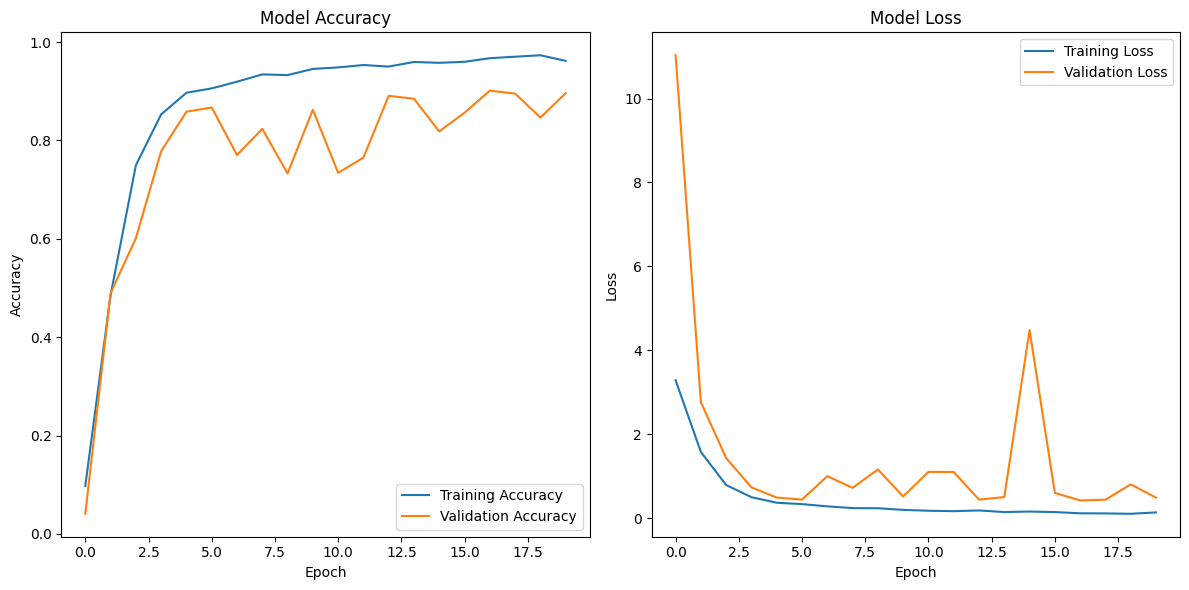

In [ ]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()


In [ ]:
y_pred = model.predict(X_test)
y_pred_labels = np.argmax(y_pred, axis=1)

48/48 [==============================] - 1s 29ms/step


In [ ]:
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from tensorflow.keras.utils import to_categorical

# Convert integer class labels to one-hot encoded format
y_pred_labels_onehot = to_categorical(y_pred_labels, num_classes=38)

# Compute accuracy
accuracy = accuracy_score(y_test, y_pred_labels_onehot)
print("Accuracy:", accuracy)

# Calculate precision, recall, and F1-score for each class
precision = precision_score(y_test, y_pred_labels_onehot, average='macro')
recall = recall_score(y_test, y_pred_labels_onehot, average='macro')
f1 = f1_score(y_test, y_pred_labels_onehot, average='macro')

print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)


Accuracy: 0.8960526315789473
Precision: 0.911894158783048
Recall: 0.8960526315789473
F1 Score: 0.8956012940457421


In [ ]:
# Generate and print the classification report
report = classification_report(y_test, y_pred_labels_onehot)
print(report)

              precision    recall  f1-score   support

           0       0.80      0.97      0.88        40
           1       0.92      0.90      0.91        40
           2       0.86      0.93      0.89        40
           3       0.95      1.00      0.98        40
           4       0.70      0.95      0.81        40
           5       0.81      0.88      0.84        40
           6       1.00      0.78      0.87        40
           7       1.00      0.90      0.95        40
           8       0.85      1.00      0.92        40
           9       1.00      0.95      0.97        40
          10       0.92      0.88      0.90        40
          11       0.92      0.88      0.90        40
          12       1.00      0.93      0.96        40
          13       0.97      0.97      0.97        40
          14       1.00      0.90      0.95        40
          15       0.90      0.45      0.60        40
          16       0.92      0.82      0.87        40
          17       0.87    

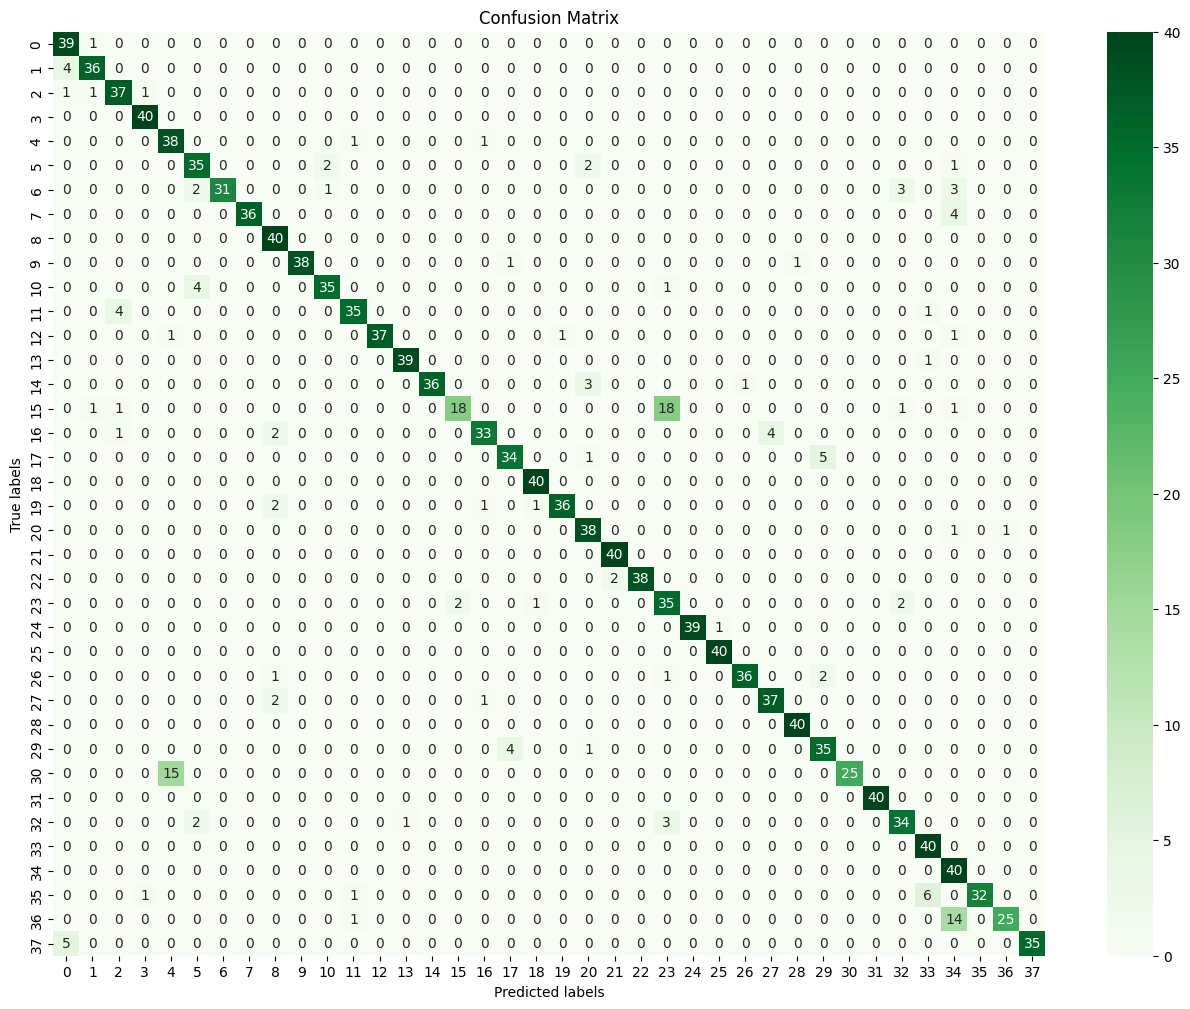

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Convert one-hot encoded y_test to integer format
y_test_int = np.argmax(y_test, axis=1)

# Compute confusion matrix
conf_matrix = confusion_matrix(y_test_int, y_pred_labels)

# Plot confusion matrix
plt.figure(figsize=(16, 12))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Greens')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
from keras.models import load_model
inc_model = load_model('/content/best_models.h5')

In [ ]:
y_pred = inc_model.predict(X_test)
y_pred_labels = np.argmax(y_pred, axis=1)

48/48 [==============================] - 3s 30ms/step


In [ ]:
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from tensorflow.keras.utils import to_categorical

# Convert integer class labels to one-hot encoded format
y_pred_labels_onehot = to_categorical(y_pred_labels, num_classes=38)

# Compute accuracy
accuracy = accuracy_score(y_test, y_pred_labels_onehot)
print("Accuracy:", accuracy)

# Calculate precision, recall, and F1-score for each class
precision = precision_score(y_test, y_pred_labels_onehot, average='macro')
recall = recall_score(y_test, y_pred_labels_onehot, average='macro')
f1 = f1_score(y_test, y_pred_labels_onehot, average='macro')

print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)


Accuracy: 0.9013157894736842
Precision: 0.9131447814494296
Recall: 0.9013157894736842
F1 Score: 0.9005198150450378


In [ ]:
# Generate and print the classification report
report = classification_report(y_test, y_pred_labels_onehot)
print(report)

              precision    recall  f1-score   support

           0       0.83      0.95      0.88        40
           1       0.95      0.95      0.95        40
           2       1.00      0.95      0.97        40
           3       0.93      0.97      0.95        40
           4       0.84      0.90      0.87        40
           5       0.80      0.93      0.86        40
           6       0.81      0.95      0.87        40
           7       1.00      0.90      0.95        40
           8       0.93      0.93      0.93        40
           9       0.98      1.00      0.99        40
          10       0.82      0.80      0.81        40
          11       0.83      1.00      0.91        40
          12       0.97      0.93      0.95        40
          13       0.95      0.95      0.95        40
          14       0.95      0.97      0.96        40
          15       0.64      0.88      0.74        40
          16       0.81      0.55      0.66        40
          17       0.89    

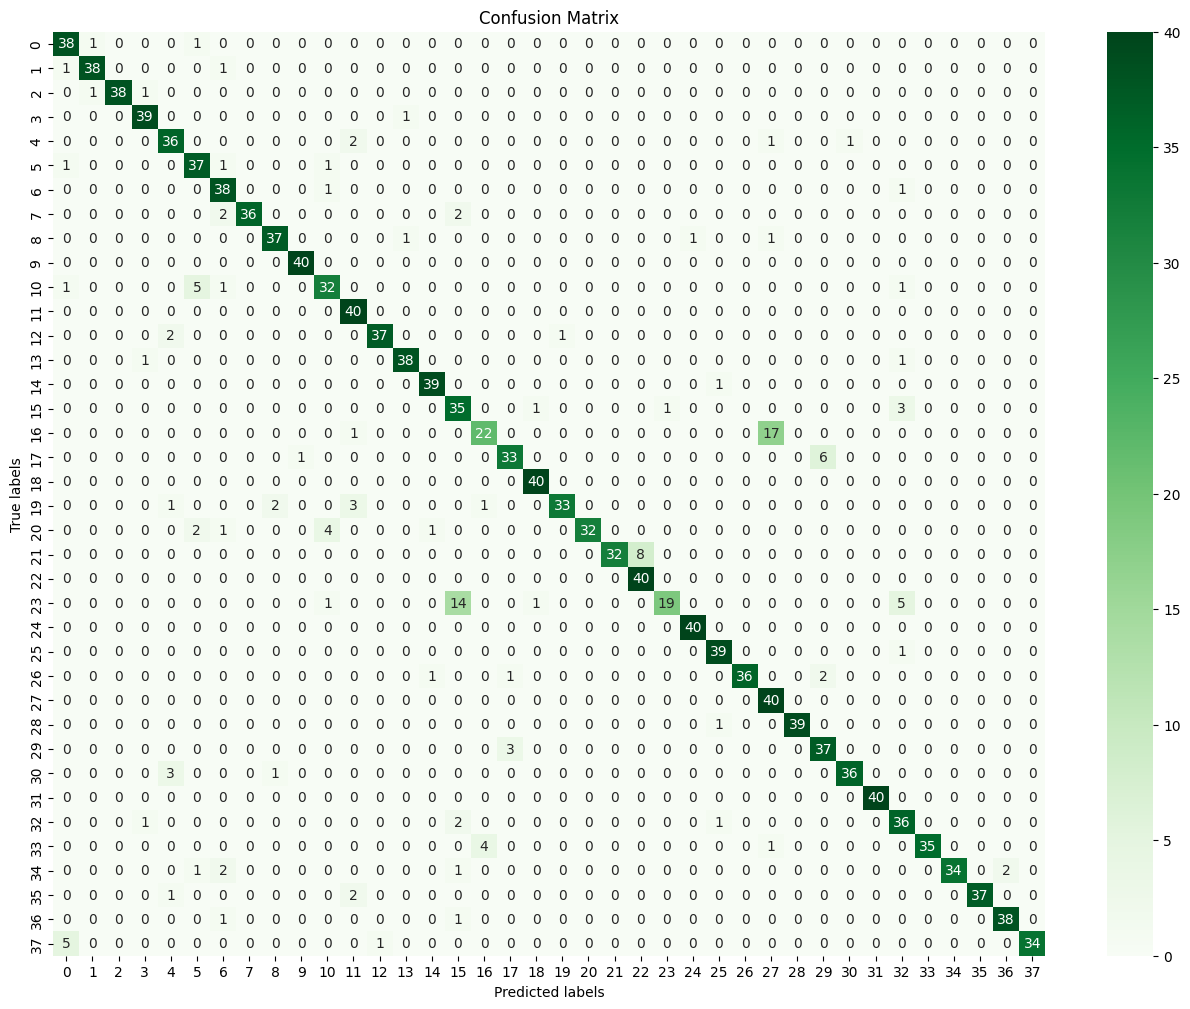

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Convert one-hot encoded y_test to integer format
y_test_int = np.argmax(y_test, axis=1)

# Compute confusion matrix
conf_matrix = confusion_matrix(y_test_int, y_pred_labels)

# Plot confusion matrix
plt.figure(figsize=(16, 12))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Greens')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from google.colab import drive
import shutil

# Mount Google Drive
drive.mount('/content/drive')

# Define paths
source_path = '/content/best_models.h5'
destination_path = '/content/drive/MyDrive/Thesis/Model/BSL/best_model_acc_90.h5'

# Copy the model file to Google Drive
shutil.copyfile(source_path, destination_path)

# Confirm successful copy
print("Model saved to Google Drive successfully.")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Model saved to Google Drive successfully.


### **Acc 90**

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.applications import InceptionV3

# Load the InceptionV3 model pretrained on ImageNet
model = InceptionV3(weights='imagenet', input_shape=(150, 150, 3), include_top=False)

# Display model summary
model.summary()

# Flatten the output of the last convolutional layer
flat1 = Flatten()(model.layers[-1].output)

# Add Dense layers for classification
class1 = Dense(1024, activation='relu')(flat1)
class2 = Dense(512, activation='relu')(class1)
class3 = Dense(256, activation='relu')(class2)
class4 = Dense(128, activation='relu')(class3)

# Output layer with softmax activation for 38 classes
output = Dense(38, activation='softmax')(class4)

# Define new model
model = Model(inputs=model.inputs, outputs=output)

# Display model summary
model.summary()

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Define a callback to save the model with the highest validation accuracy
checkpoint = ModelCheckpoint('best_model.h5', monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_5 (InputLayer)        [(None, 150, 150, 3)]        0         []                            
                                                                                                  
 conv2d_376 (Conv2D)         (None, 74, 74, 32)           864       ['input_5[0][0]']             
                                                                                                  
 batch_normalization_376 (B  (None, 74, 74, 32)           96        ['conv2d_376[0][0]']          
 atchNormalization)                                                                               
                                                                                                  
 activation_376 (Activation  (None, 74, 74, 32)           0         ['batch_normalizati

In [ ]:
history = model.fit(
    X_train,y_train,batch_size=64,
    validation_data=(X_test, y_test),
    epochs=30,
    callbacks=[checkpoint]
)

Epoch 1/30
173/173 [==============================] - ETA: 0s - loss: 3.4051 - accuracy: 0.0614
Epoch 1: val_accuracy improved from -inf to 0.02632, saving model to best_model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


173/173 [==============================] - 80s 252ms/step - loss: 3.4051 - accuracy: 0.0614 - val_loss: 89.7522 - val_accuracy: 0.0263
Epoch 2/30
173/173 [==============================] - ETA: 0s - loss: 1.9061 - accuracy: 0.3641
Epoch 2: val_accuracy improved from 0.02632 to 0.42105, saving model to best_model.h5
173/173 [==============================] - 41s 239ms/step - loss: 1.9061 - accuracy: 0.3641 - val_loss: 1.8474 - val_accuracy: 0.4211
Epoch 3/30
173/173 [==============================] - ETA: 0s - loss: 1.0181 - accuracy: 0.6594
Epoch 3: val_accuracy improved from 0.42105 to 0.57895, saving model to best_model.h5
173/173 [==============================] - 42s 241ms/step - loss: 1.0181 - accuracy: 0.6594 - val_loss: 1.9051 - val_accuracy: 0.5789
Epoch 4/30
173/173 [==============================] - ETA: 0s - loss: 0.6496 - accuracy: 0.7892
Epoch 4: val_accuracy improved from 0.57895 to 0.74671, saving model to best_model.h5
173/173 [==============================] - 38s 221m

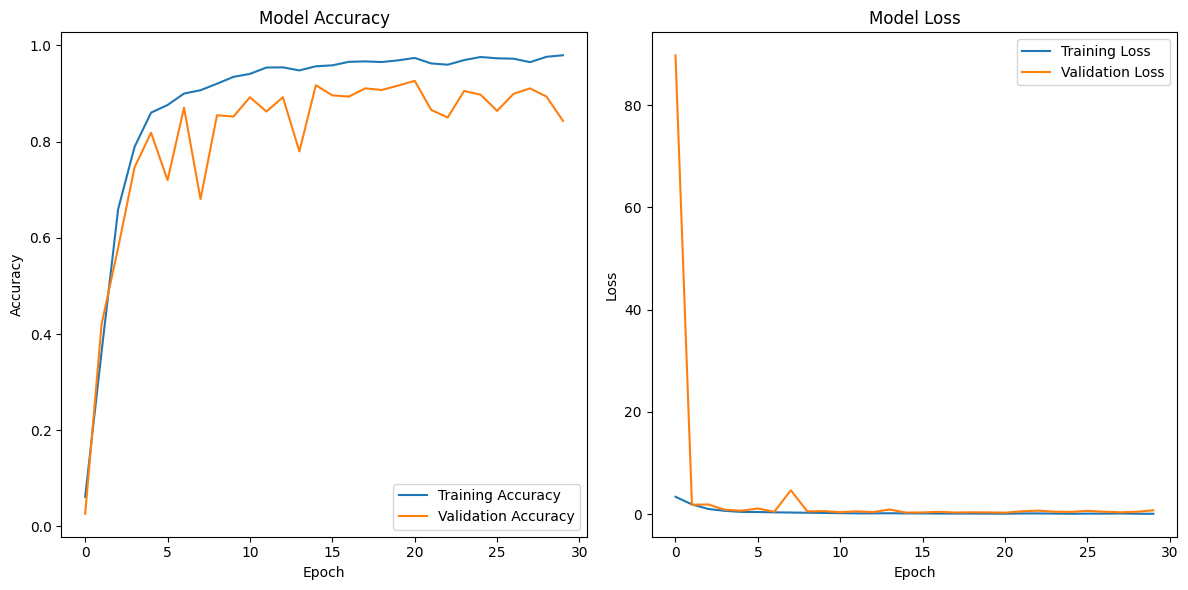

In [ ]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()


In [ ]:
y_pred = model.predict(X_test)
y_pred_labels = np.argmax(y_pred, axis=1)

48/48 [==============================] - 3s 30ms/step


In [ ]:
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from tensorflow.keras.utils import to_categorical

# Convert integer class labels to one-hot encoded format
y_pred_labels_onehot = to_categorical(y_pred_labels, num_classes=38)

# Compute accuracy
accuracy = accuracy_score(y_test, y_pred_labels_onehot)
print("Accuracy:", accuracy)

# Calculate precision, recall, and F1-score for each class
precision = precision_score(y_test, y_pred_labels_onehot, average='macro')
recall = recall_score(y_test, y_pred_labels_onehot, average='macro')
f1 = f1_score(y_test, y_pred_labels_onehot, average='macro')

print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)


Accuracy: 0.8427631578947369
Precision: 0.8638235257153919
Recall: 0.842763157894737
F1 Score: 0.8403421527057552


In [ ]:
# Generate and print the classification report
report = classification_report(y_test, y_pred_labels_onehot)
print(report)

              precision    recall  f1-score   support

           0       0.85      0.57      0.69        40
           1       0.88      0.93      0.90        40
           2       0.67      0.95      0.78        40
           3       0.64      0.97      0.77        40
           4       0.73      0.88      0.80        40
           5       0.92      0.85      0.88        40
           6       0.62      0.97      0.76        40
           7       0.95      0.88      0.91        40
           8       0.95      0.93      0.94        40
           9       0.92      0.85      0.88        40
          10       0.84      0.78      0.81        40
          11       1.00      0.68      0.81        40
          12       0.97      0.95      0.96        40
          13       0.88      0.95      0.92        40
          14       0.94      0.85      0.89        40
          15       0.75      0.68      0.71        40
          16       0.84      0.95      0.89        40
          17       0.87    

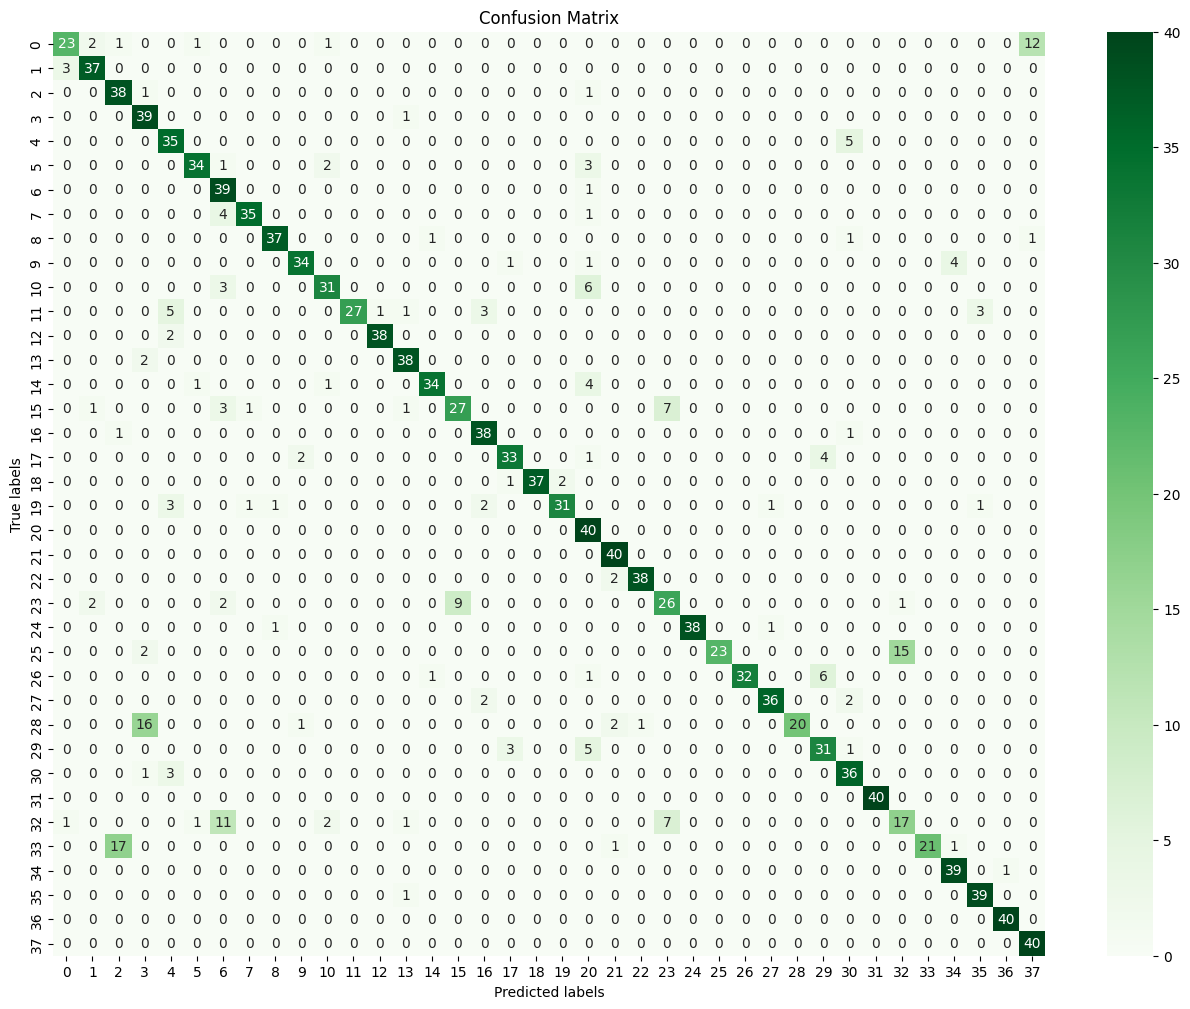

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Convert one-hot encoded y_test to integer format
y_test_int = np.argmax(y_test, axis=1)

# Compute confusion matrix
conf_matrix = confusion_matrix(y_test_int, y_pred_labels)

# Plot confusion matrix
plt.figure(figsize=(16, 12))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Greens')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
from keras.models import load_model
inc_model = load_model('/content/best_model.h5')

In [ ]:
y_pred = inc_model.predict(X_test)
y_pred_labels = np.argmax(y_pred, axis=1)

48/48 [==============================] - 3s 30ms/step


In [ ]:
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from tensorflow.keras.utils import to_categorical

# Convert integer class labels to one-hot encoded format
y_pred_labels_onehot = to_categorical(y_pred_labels, num_classes=38)

# Compute accuracy
accuracy = accuracy_score(y_test, y_pred_labels_onehot)
print("Accuracy:", accuracy)

# Calculate precision, recall, and F1-score for each class
precision = precision_score(y_test, y_pred_labels_onehot, average='macro')
recall = recall_score(y_test, y_pred_labels_onehot, average='macro')
f1 = f1_score(y_test, y_pred_labels_onehot, average='macro')

print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)


Accuracy: 0.9263157894736842
Precision: 0.9307194156444263
Recall: 0.9263157894736844
F1 Score: 0.9257326884843057


In [ ]:
# Generate and print the classification report
report = classification_report(y_test, y_pred_labels_onehot)
print(report)

              precision    recall  f1-score   support

           0       0.91      0.80      0.85        40
           1       0.91      0.97      0.94        40
           2       0.97      0.90      0.94        40
           3       0.93      1.00      0.96        40
           4       0.94      0.75      0.83        40
           5       0.88      0.93      0.90        40
           6       0.78      0.95      0.85        40
           7       1.00      0.88      0.93        40
           8       0.93      0.97      0.95        40
           9       1.00      1.00      1.00        40
          10       0.92      0.82      0.87        40
          11       0.93      0.93      0.93        40
          12       1.00      0.97      0.99        40
          13       0.97      0.95      0.96        40
          14       0.89      0.97      0.93        40
          15       0.69      0.88      0.77        40
          16       0.89      0.97      0.93        40
          17       0.82    

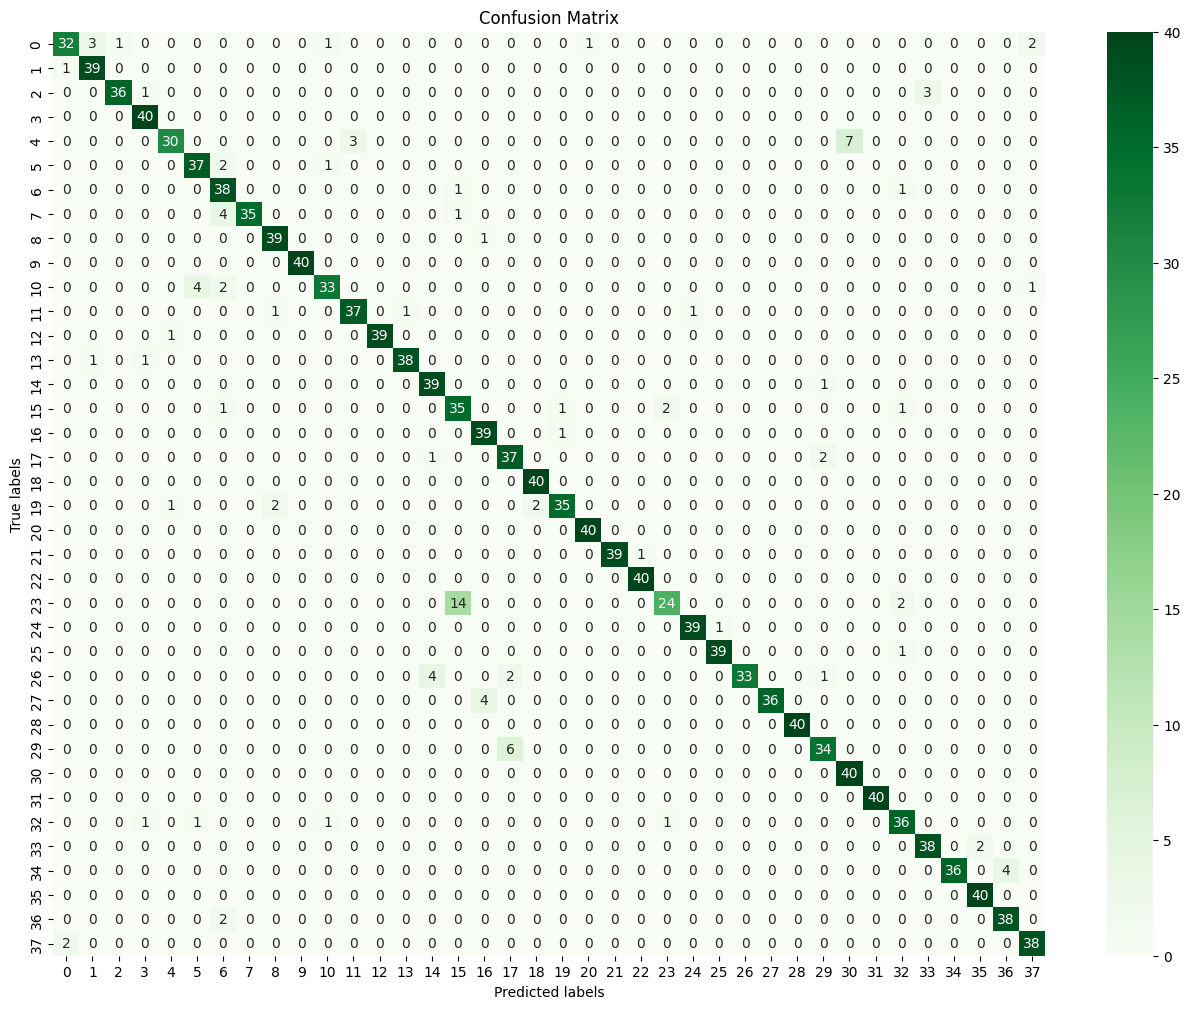

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Convert one-hot encoded y_test to integer format
y_test_int = np.argmax(y_test, axis=1)

# Compute confusion matrix
conf_matrix = confusion_matrix(y_test_int, y_pred_labels)

# Plot confusion matrix
plt.figure(figsize=(16, 12))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Greens')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from google.colab import drive
import shutil

# Mount Google Drive
drive.mount('/content/drive')

# Define paths
source_path = '/content/best_model.h5'
destination_path = '/content/drive/MyDrive/Thesis/Model/BSL/best_model_acc_92.h5'

# Copy the model file to Google Drive
shutil.copyfile(source_path, destination_path)

# Confirm successful copy
print("Model saved to Google Drive successfully.")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Model saved to Google Drive successfully.


# EfficientNet B1






*   Preprocess -> Sharpness,Remove Noise,Image ,augmentation
*   Model -> ResNet50 (No regularizer and Learning Rate)
*   Accuracy -> 85





In [ ]:
#upload the kaggle json
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!kaggle datasets download -d safiullah007/bangla-sign-language-augmented-dataset

 99% 165M/166M [00:06<00:00, 29.3MB/s]
100% 166M/166M [00:06<00:00, 27.3MB/s]


In [ ]:
# unzip the file
import zipfile
zip_ref = zipfile.ZipFile('/content/bangla-sign-language-augmented-dataset.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

In [ ]:
import keras
from PIL import Image
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import cv2
from sklearn.utils import shuffle
import tensorflow as tf
import os
import numpy as np
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from tensorflow.keras.optimizers import Adam

In [ ]:
import os
import cv2
import numpy as np

def enhance_sharpness(image, alpha=2.5, beta=-1.5, kernel_size=(5, 5)):
    blurred = cv2.GaussianBlur(image, kernel_size, 0)
    return cv2.addWeighted(image, alpha, blurred, beta, 0)

def remove_noise(image, kernel_size=(5, 5)):
    blurred = cv2.GaussianBlur(image, kernel_size, 0)
    return blurred

def resizing_image(image, width, height):
    resized_image = cv2.resize(image, (width, height))
    return resized_image

def modified_image(image_path):
    image = cv2.imread(image_path)
    resized_image = resizing_image(image, 64, 64)
    denoised_image = remove_noise(resized_image)
    sharpness_image = enhance_sharpness(denoised_image)
    return sharpness_image

In [ ]:
main_folder_path = "/content/AUGMENTED_DATASET"

data = []
labels = []


for folder_name in os.listdir(main_folder_path):
    folder_path = os.path.join(main_folder_path, folder_name)

    # Check if the path is a directory
    if os.path.isdir(folder_path):
        # Traverse each image in the folder
        for image_name in tqdm(os.listdir(folder_path), desc=folder_name):
            image_path = os.path.join(folder_path, image_name)

            # Process the image
            image = modified_image(image_path)

            # Append the image to the data list
            data.append(image)

            # Append the label (folder name) to the labels list
            labels.append(folder_name)

# Convert lists to numpy arrays for further processing if needed
data = np.array(data)
labels = np.array(labels)


14: 100%|██████████| 834/834 [00:00<00:00, 1053.41it/s]


In [ ]:
print(len(data))
print(len(labels))

33182
33182


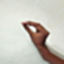

In [ ]:
cv2_imshow(data[0])

In [ ]:
label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(labels)
x = (data) # image independent
y = (labels) # label dependent
print("type of x independent varible which contain images :",type(x))
print("type of y dependent variable which contain the image label",type(y))
x,y = shuffle(x,y,random_state = 101)
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size = 0.2,random_state =1)


from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder()
y_train_encoded = encoder.fit_transform(y_train.reshape(-1, 1)).toarray()

y_test_encoded = encoder.fit_transform(y_test.reshape(-1, 1)).toarray()

type of x independent varible which contain images : <class 'numpy.ndarray'>
type of y dependent variable which contain the image label <class 'numpy.ndarray'>


In [ ]:
# augmentation
from keras.preprocessing.image import ImageDataGenerator

x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], x_train.shape[2], 3))

# Create an instance of the ImageDataGenerator with desired augmentation settings
datagen = ImageDataGenerator(

    width_shift_range=0.1,  # Fraction of total width
    height_shift_range=0.1,  # Fraction of total height
    shear_range=0.2,  # Shear intensity
    zoom_range=0.2,  # Zoom range
    horizontal_flip=True,  # Horizontal flipping
    fill_mode='nearest'  # How to fill in newly created pixels
)

# Fit the ImageDataGenerator on your reshaped training data
datagen.fit(x_train)

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.applications import EfficientNetB1

# Load the EfficientNetB1 model pretrained on ImageNet
model = EfficientNetB1(weights='imagenet', input_shape=(64, 64, 3), include_top=False)

# Display model summary
model.summary()

# Flatten the output of the last convolutional layer
flat1 = Flatten()(model.layers[-1].output)

# Add Dense layers for classification
class1 = Dense(1024, activation='relu')(flat1)
class2 = Dense(512, activation='relu')(class1)
class3 = Dense(256, activation='relu')(class2)
class4 = Dense(128, activation='relu')(class3)

# Output layer with softmax activation for 38 classes
output = Dense(38, activation='softmax')(class4)

# Define new model
model = Model(inputs=model.inputs, outputs=output)

# Display model summary
model.summary()

Model: "efficientnetb1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 64, 64, 3)]          0         []                            
                                                                                                  
 rescaling_2 (Rescaling)     (None, 64, 64, 3)            0         ['input_2[0][0]']             
                                                                                                  
 normalization_1 (Normaliza  (None, 64, 64, 3)            7         ['rescaling_2[0][0]']         
 tion)                                                                                            
                                                                                                  
 rescaling_3 (Rescaling)     (None, 64, 64, 3)            0         ['normalization_1

In [ ]:
custom_optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=custom_optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint
# checkpoint = ModelCheckpoint('/content/drive/MyDrive/BdSL/best_model_resNEt50.h5', monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)
checkpoint = tf.keras.callbacks.ModelCheckpoint('/content/drive/MyDrive/Thesis/Model/BSL/Efficient/best_model_efficient_30epcs.h5',
                                                    monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=True)
history = model.fit(
    datagen.flow(x_train, y_train_encoded, batch_size=64),
    # x_train,y_train_encoded,batch_size=64,
    # validation_data=(x_test, y_train_encoded),
    # validation_split =  0.1,
    validation_data=(x_test, y_test_encoded),
    epochs=30,
    callbacks=[checkpoint]

)

Epoch 1/30
415/415 [==============================] - ETA: 0s - loss: 1.9721 - accuracy: 0.4310
Epoch 1: val_loss improved from inf to 1.30910, saving model to /content/drive/MyDrive/Thesis/Model/BSL/Efficient/best_model_efficient_30epcs.h5
415/415 [==============================] - 124s 162ms/step - loss: 1.9721 - accuracy: 0.4310 - val_loss: 1.3091 - val_accuracy: 0.6167
Epoch 2/30
415/415 [==============================] - ETA: 0s - loss: 1.0586 - accuracy: 0.6931
Epoch 2: val_loss improved from 1.30910 to 0.88726, saving model to /content/drive/MyDrive/Thesis/Model/BSL/Efficient/best_model_efficient_30epcs.h5
415/415 [==============================] - 61s 147ms/step - loss: 1.0586 - accuracy: 0.6931 - val_loss: 0.8873 - val_accuracy: 0.7473
Epoch 3/30
415/415 [==============================] - ETA: 0s - loss: 0.7952 - accuracy: 0.7662
Epoch 3: val_loss improved from 0.88726 to 0.75856, saving model to /content/drive/MyDrive/Thesis/Model/BSL/Efficient/best_model_efficient_30epcs.h5


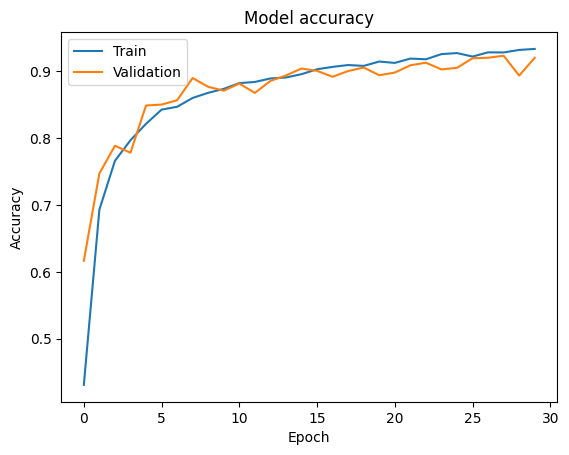

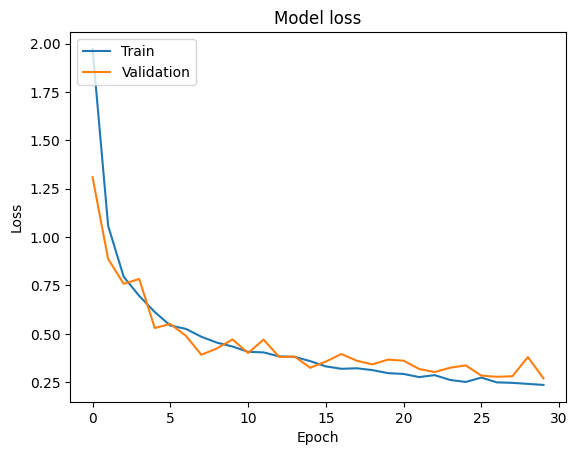

In [ ]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [ ]:
model.load_weights('/content/drive/MyDrive/Thesis/Model/BSL/Efficient/best_model_efficient_30epcs.h5')
y_pred = model.predict(x_test)
y_pred_labels = np.argmax(y_pred, axis=1)

accuracy = accuracy_score(y_test, y_pred_labels)
print("Accuracy:", accuracy)

# Calculate precision, recall, and F1-score for each class
precision = precision_score(y_test, y_pred_labels, average='macro')
recall = recall_score(y_test, y_pred_labels, average='macro')
f1 = f1_score(y_test, y_pred_labels, average='macro')

print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

208/208 [==============================] - 7s 18ms/step
Accuracy: 0.9204459846316106
Precision: 0.9244667297760882
Recall: 0.9196756278479687
F1 Score: 0.920139419371677


In [ ]:
# Generate and print the classification report
report = classification_report(y_test, y_pred_labels)
print(report)

              precision    recall  f1-score   support

           0       0.93      0.88      0.91       180
           1       0.97      0.97      0.97       178
           2       0.94      0.97      0.96       193
           3       0.99      0.91      0.95       156
           4       0.96      0.93      0.94       177
           5       0.99      0.73      0.84       185
           6       0.93      0.92      0.92       166
           7       0.86      0.94      0.90       167
           8       0.92      0.98      0.95       188
           9       0.96      0.96      0.96       179
          10       0.74      0.96      0.84       186
          11       0.92      0.79      0.85       159
          12       0.96      0.97      0.97       192
          13       0.97      0.94      0.95       190
          14       0.95      0.94      0.94       171
          15       0.74      0.89      0.81       179
          16       0.85      0.80      0.82       165
          17       0.97    

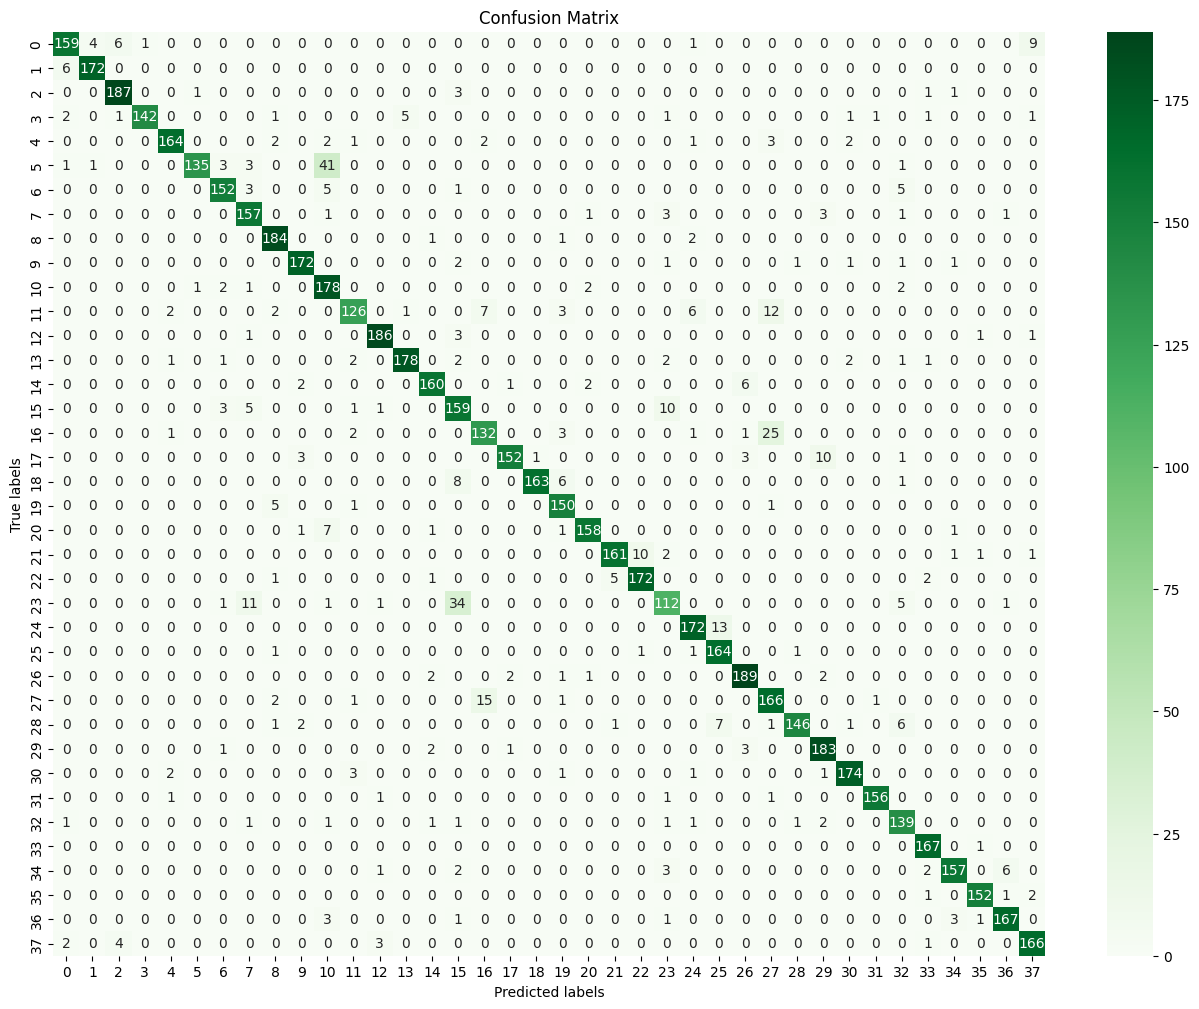

In [ ]:
conf_matrix = confusion_matrix(y_test, y_pred_labels)

# Plot confusion matrix
plt.figure(figsize=(16, 12))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Greens')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

1/1 [==============================] - 0s 27ms/step


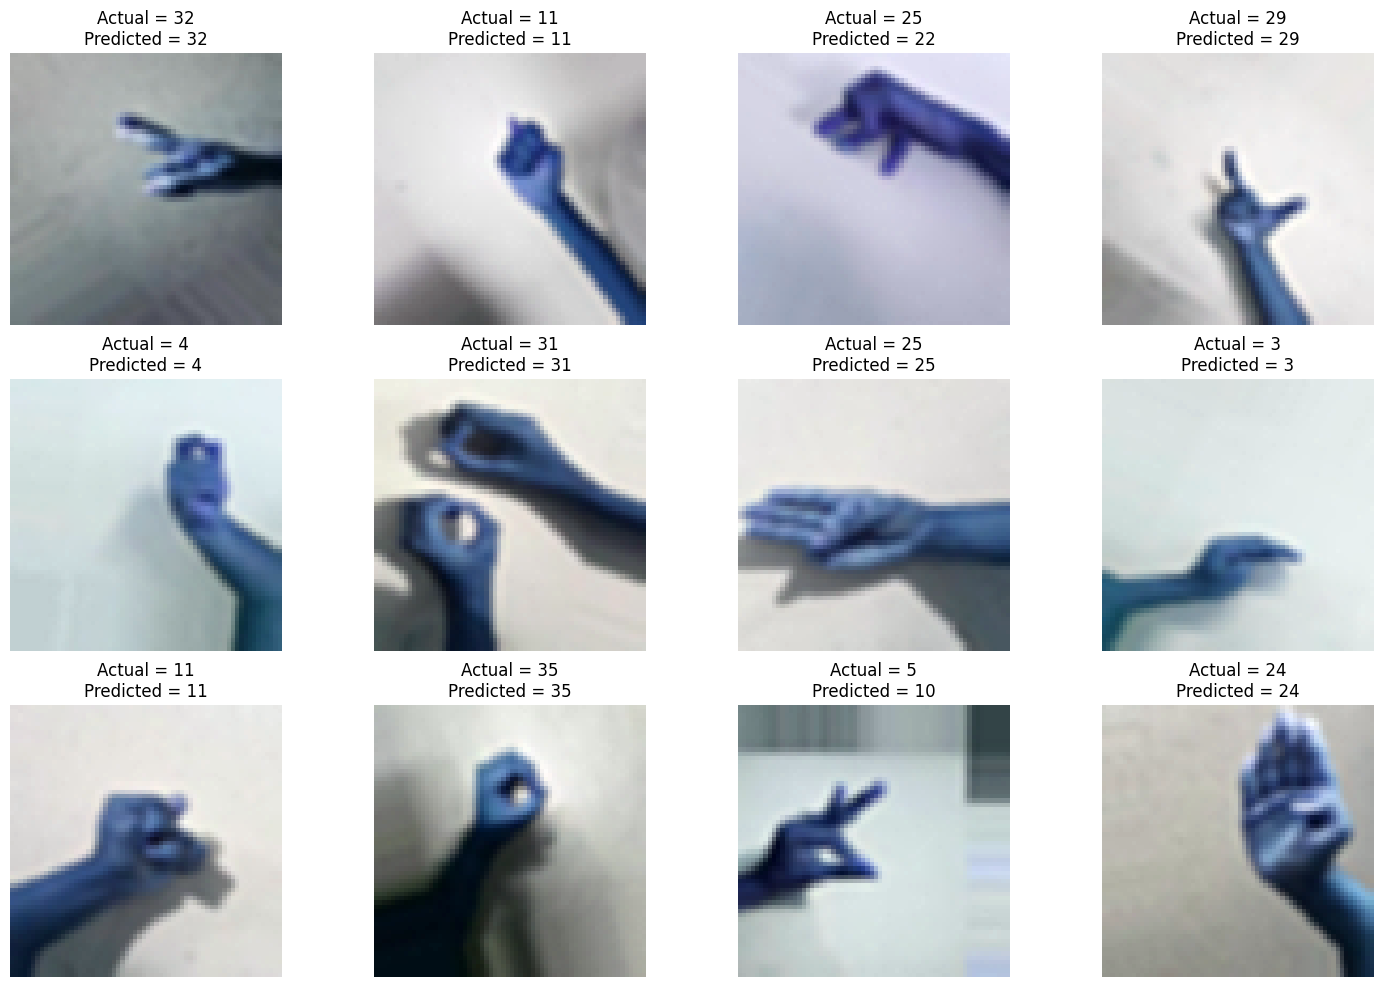

In [ ]:
import random


# Select 12 random indices from x_test
random_indices = random.sample(range(len(x_test)), 12)

plt.figure(figsize=(18, 12))
j = 1
for i in random_indices:
    plt.subplot(3, 4, j)
    j += 1
    plt.imshow(x_test[i], cmap='Greys')

    # Convert one-hot encoded y_test to integer label
    actual_label = (y_test[i])
    predicted_label = np.argmax(model.predict(x_test[i].reshape(1, *x_test[i].shape)))

    # Display only actual and predicted values
    plt.title('Actual = {}\nPredicted = {}'.format(actual_label, predicted_label))
    plt.axis(False)

plt.show()


In [ ]:
model.save('/content/drive/MyDrive/Thesis/Model/BSL/Efficient/best_model_efficient_30epcs_main.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint
# checkpoint = ModelCheckpoint('/content/drive/MyDrive/BdSL/best_model_resNEt50.h5', monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)
checkpoint = tf.keras.callbacks.ModelCheckpoint('/content/drive/MyDrive/Thesis/Model/BSL/Efficient/best_model_efficient_30epcs.h5',
                                                    monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=True)
history = model.fit(
    datagen.flow(x_train, y_train_encoded, batch_size=64),
    # x_train,y_train_encoded,batch_size=64,
    # validation_data=(x_test, y_train_encoded),
    # validation_split =  0.1,
    validation_data=(x_test, y_test_encoded),
    epochs=50,
    callbacks=[checkpoint]

)

Epoch 1/50
415/415 [==============================] - ETA: 0s - loss: 0.2240 - accuracy: 0.9358
Epoch 1: val_loss improved from inf to 0.26272, saving model to /content/drive/MyDrive/Thesis/Model/BSL/Efficient/best_model_efficient_30epcs.h5
415/415 [==============================] - 60s 144ms/step - loss: 0.2240 - accuracy: 0.9358 - val_loss: 0.2627 - val_accuracy: 0.9302
Epoch 2/50
415/415 [==============================] - ETA: 0s - loss: 0.2172 - accuracy: 0.9367
Epoch 2: val_loss did not improve from 0.26272
415/415 [==============================] - 57s 137ms/step - loss: 0.2172 - accuracy: 0.9367 - val_loss: 0.2884 - val_accuracy: 0.9206
Epoch 3/50
415/415 [==============================] - ETA: 0s - loss: 0.2238 - accuracy: 0.9351
Epoch 3: val_loss improved from 0.26272 to 0.24447, saving model to /content/drive/MyDrive/Thesis/Model/BSL/Efficient/best_model_efficient_30epcs.h5
415/415 [==============================] - 59s 143ms/step - loss: 0.2238 - accuracy: 0.9351 - val_loss:

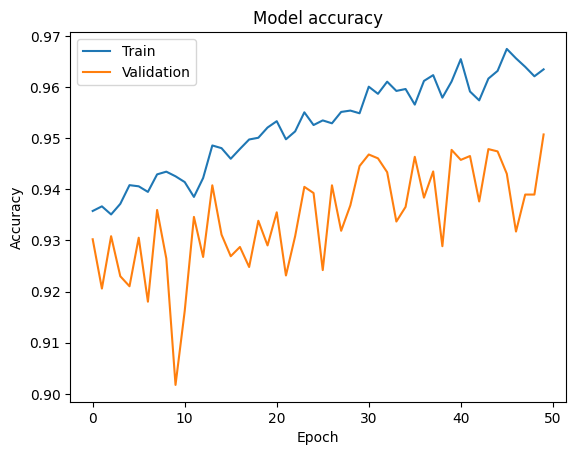

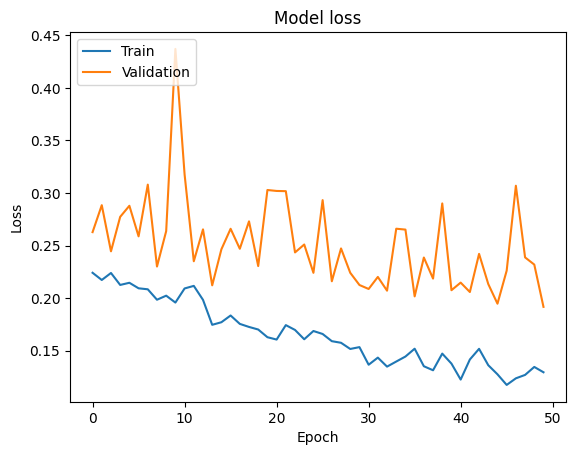

In [ ]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [ ]:
model.load_weights('/content/drive/MyDrive/Thesis/Model/BSL/Efficient/best_model_efficient_30epcs.h5')
y_pred = model.predict(x_test)
y_pred_labels = np.argmax(y_pred, axis=1)

accuracy = accuracy_score(y_test, y_pred_labels)
print("Accuracy:", accuracy)

  # Calculate precision, recall, and F1-score for each class
precision = precision_score(y_test, y_pred_labels, average='macro')
recall = recall_score(y_test, y_pred_labels, average='macro')
f1 = f1_score(y_test, y_pred_labels, average='macro')

print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

208/208 [==============================] - 3s 14ms/step
Accuracy: 0.9507307518457134
Precision: 0.951546211904341
Recall: 0.9507651806902894
F1 Score: 0.9506794811566701


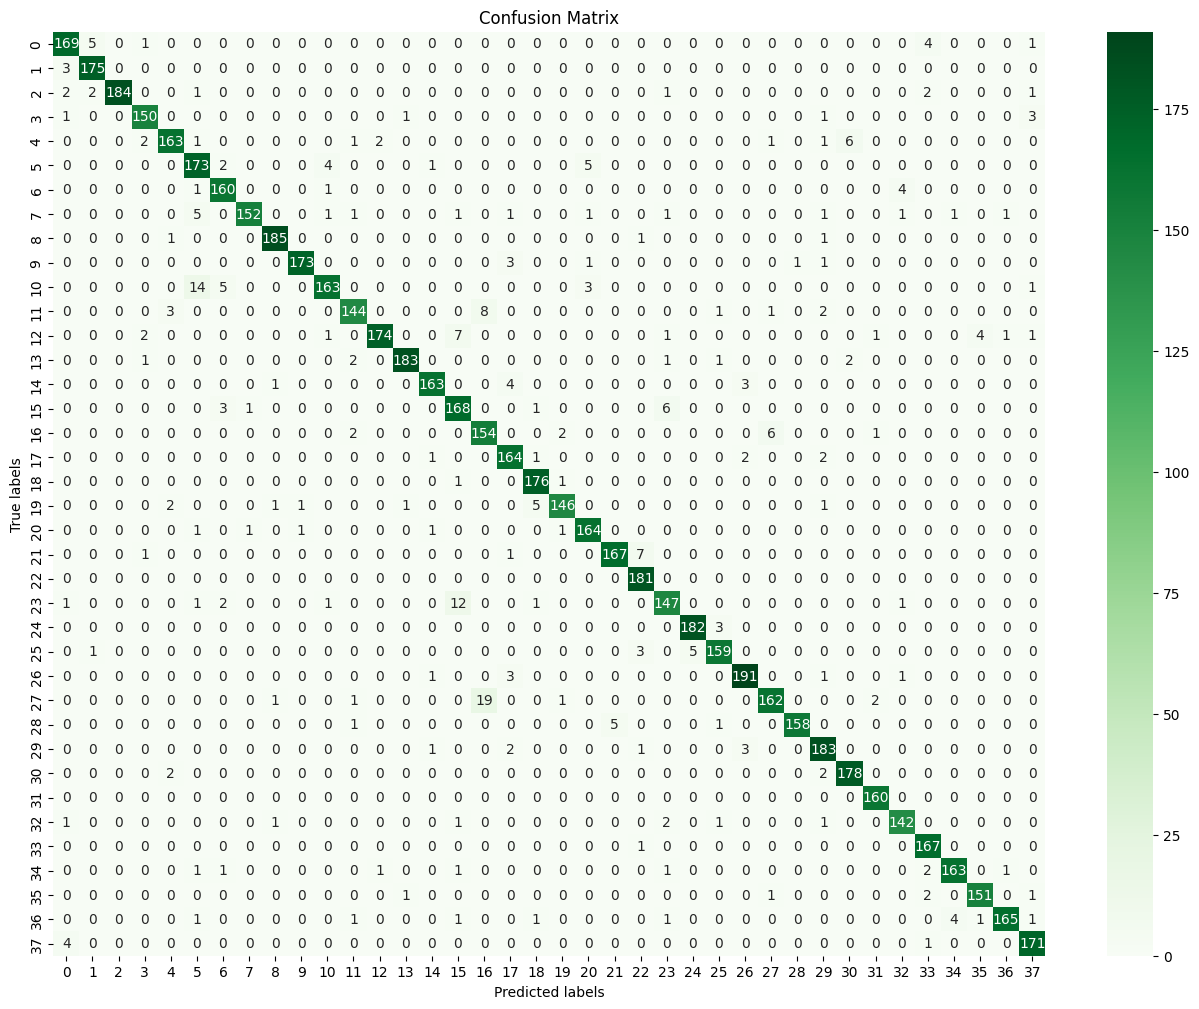

In [ ]:
conf_matrix = confusion_matrix(y_test, y_pred_labels)

# Plot confusion matrix
plt.figure(figsize=(16, 12))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Greens')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

1/1 [==============================] - 0s 29ms/step


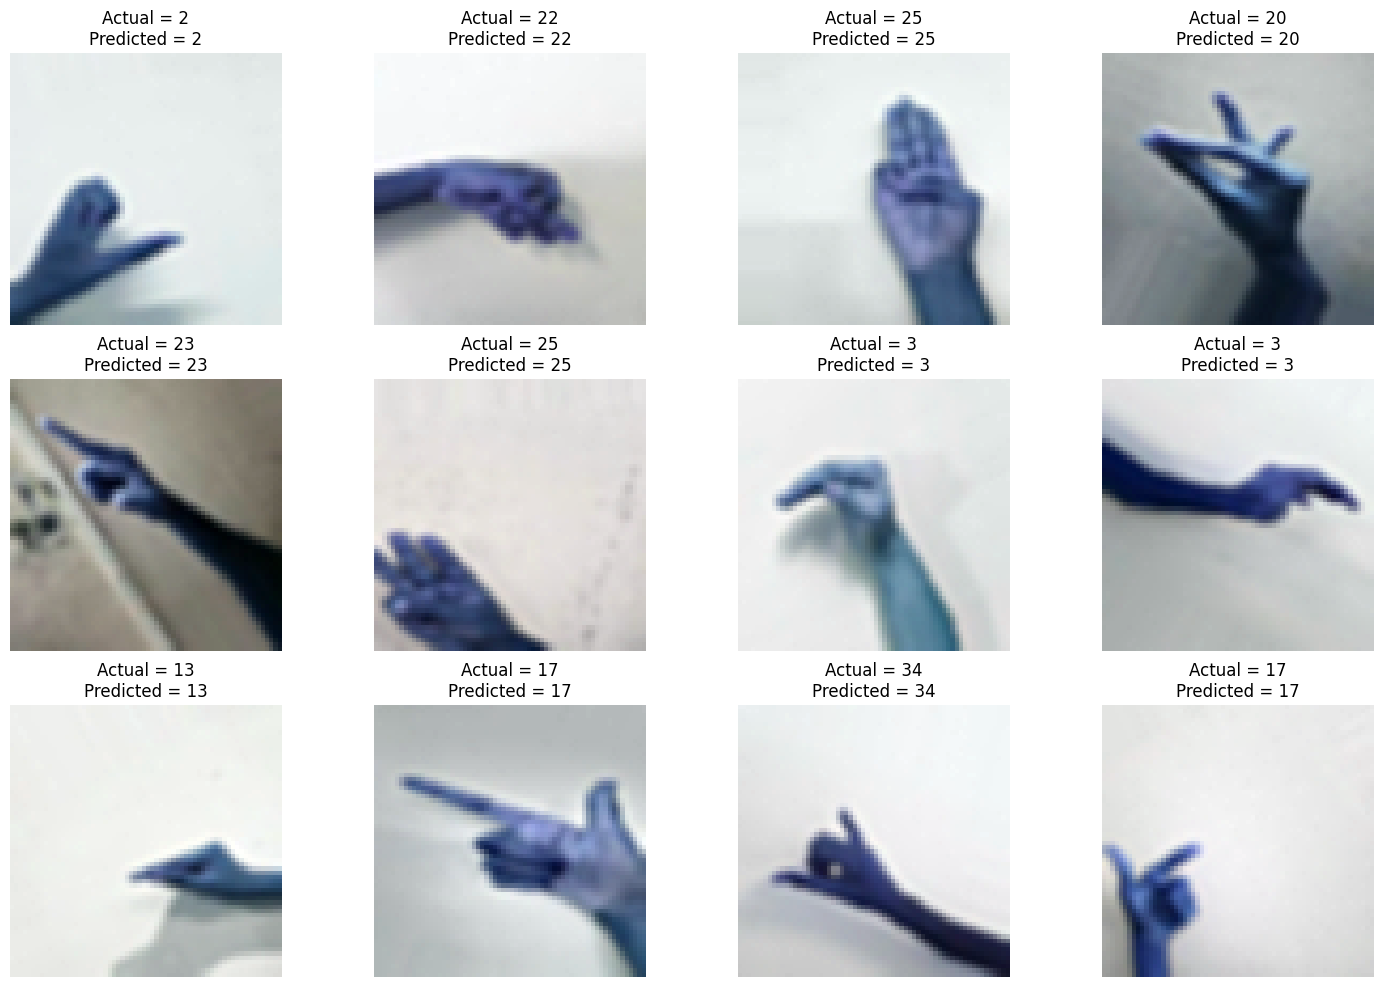

In [ ]:
import random


# Select 12 random indices from x_test
random_indices = random.sample(range(len(x_test)), 12)

plt.figure(figsize=(18, 12))
j = 1
for i in random_indices:
    plt.subplot(3, 4, j)
    j += 1
    plt.imshow(x_test[i], cmap='Greys')

    # Convert one-hot encoded y_test to integer label
    actual_label = (y_test[i])
    predicted_label = np.argmax(model.predict(x_test[i].reshape(1, *x_test[i].shape)))

    # Display only actual and predicted values
    plt.title('Actual = {}\nPredicted = {}'.format(actual_label, predicted_label))
    plt.axis(False)

plt.show()


In [ ]:
model.save('/content/drive/MyDrive/Thesis/Model/BSL/Efficient/best_model_efficient_50epcs_95_acc.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
from keras.models import load_model
efficientmodel = load_model('/content/drive/MyDrive/Thesis/Model/BSL/Efficient/best_model_efficient_50epcs_95_acc.h5')

y_pred = efficientmodel.predict(x_test)
y_pred_labels = np.argmax(y_pred, axis=1)

accuracy = accuracy_score(y_test, y_pred_labels)
print("Accuracy:", accuracy)

  # Calculate precision, recall, and F1-score for each class
precision = precision_score(y_test, y_pred_labels, average='macro')
recall = recall_score(y_test, y_pred_labels, average='macro')
f1 = f1_score(y_test, y_pred_labels, average='macro')

print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

208/208 [==============================] - 6s 13ms/step
Accuracy: 0.9507307518457134
Precision: 0.951546211904341
Recall: 0.9507651806902894
F1 Score: 0.9506794811566701


# DenseNet121






*   Preprocess -> Sharpness,Remove Noise,Image ,augmentation
*   Model -> ResNet50 (No regularizer and Learning Rate)
*   Accuracy -> 85





In [ ]:
#upload the kaggle json
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!kaggle datasets download -d safiullah007/bangla-sign-language-augmented-dataset

 97% 161M/166M [00:03<00:00, 50.2MB/s]
100% 166M/166M [00:03<00:00, 54.1MB/s]


In [ ]:
# unzip the file
import zipfile
zip_ref = zipfile.ZipFile('/content/bangla-sign-language-augmented-dataset.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

In [ ]:
import keras
from PIL import Image
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import cv2
from sklearn.utils import shuffle
import tensorflow as tf
import os
import numpy as np
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from tensorflow.keras.optimizers import Adam

In [ ]:
import os
import cv2
import numpy as np

def enhance_sharpness(image, alpha=2.5, beta=-1.5, kernel_size=(5, 5)):
    blurred = cv2.GaussianBlur(image, kernel_size, 0)
    return cv2.addWeighted(image, alpha, blurred, beta, 0)

def remove_noise(image, kernel_size=(5, 5)):
    blurred = cv2.GaussianBlur(image, kernel_size, 0)
    return blurred

def resizing_image(image, width, height):
    resized_image = cv2.resize(image, (width, height))
    return resized_image

def modified_image(image_path):
    image = cv2.imread(image_path)
    resized_image = resizing_image(image, 64, 64)
    denoised_image = remove_noise(resized_image)
    sharpness_image = enhance_sharpness(denoised_image)
    return sharpness_image

In [ ]:
main_folder_path = "/content/AUGMENTED_DATASET"

data = []
labels = []


for folder_name in os.listdir(main_folder_path):
    folder_path = os.path.join(main_folder_path, folder_name)

    # Check if the path is a directory
    if os.path.isdir(folder_path):
        # Traverse each image in the folder
        for image_name in tqdm(os.listdir(folder_path), desc=folder_name):
            image_path = os.path.join(folder_path, image_name)

            # Process the image
            image = modified_image(image_path)

            # Append the image to the data list
            data.append(image)

            # Append the label (folder name) to the labels list
            labels.append(folder_name)

# Convert lists to numpy arrays for further processing if needed
data = np.array(data)
labels = np.array(labels)


0: 100%|██████████| 882/882 [00:00<00:00, 952.77it/s]


In [ ]:
print(len(data))
print(len(labels))

33182
33182


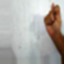

In [ ]:
cv2_imshow(data[0])

In [ ]:
label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(labels)
x = (data) # image independent
y = (labels) # label dependent
print("type of x independent varible which contain images :",type(x))
print("type of y dependent variable which contain the image label",type(y))
x,y = shuffle(x,y,random_state = 101)
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size = 0.2,random_state =1)


from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder()
y_train_encoded = encoder.fit_transform(y_train.reshape(-1, 1)).toarray()

y_test_encoded = encoder.fit_transform(y_test.reshape(-1, 1)).toarray()

type of x independent varible which contain images : <class 'numpy.ndarray'>
type of y dependent variable which contain the image label <class 'numpy.ndarray'>


In [ ]:
# augmentation
from keras.preprocessing.image import ImageDataGenerator

x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], x_train.shape[2], 3))

# Create an instance of the ImageDataGenerator with desired augmentation settings
datagen = ImageDataGenerator(

    width_shift_range=0.1,  # Fraction of total width
    height_shift_range=0.1,  # Fraction of total height
    shear_range=0.2,  # Shear intensity
    zoom_range=0.2,  # Zoom range
    horizontal_flip=True,  # Horizontal flipping
    fill_mode='nearest'  # How to fill in newly created pixels
)

# Fit the ImageDataGenerator on your reshaped training data
datagen.fit(x_train)

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.applications import DenseNet121

# Load the DenseNet121 model pretrained on ImageNet
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(64, 64, 3))

# Display model summary
base_model.summary()

# Flatten the output of the last convolutional layer
flatten_layer = Flatten()(base_model.output)

# Add Dense layers for classification
dense_layer_1 = Dense(1024, activation='relu')(flatten_layer)
dense_layer_2 = Dense(512, activation='relu')(dense_layer_1)
dense_layer_3 = Dense(256, activation='relu')(dense_layer_2)
dense_layer_4 = Dense(128, activation='relu')(dense_layer_3)

# Output layer with softmax activation for 38 classes
output_layer = Dense(38, activation='softmax')(dense_layer_4)

# Define new model
model = Model(inputs=base_model.inputs, outputs=output_layer)

# Display model summary
model.summary()


29084464/29084464 [==============================] - 0s 0us/step
Model: "densenet121"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 64, 64, 3)]          0         []                            
                                                                                                  
 zero_padding2d (ZeroPaddin  (None, 70, 70, 3)            0         ['input_1[0][0]']             
 g2D)                                                                                             
                                                                                                  
 conv1/conv (Conv2D)         (None, 32, 32, 64)           9408      ['zero_padding2d[0][0]']      
                                                                                                  
 conv1/bn (BatchNormali

In [ ]:
custom_optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=custom_optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint
# checkpoint = ModelCheckpoint('/content/drive/MyDrive/BdSL/best_model_resNEt50.h5', monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)
checkpoint = tf.keras.callbacks.ModelCheckpoint('/content/drive/MyDrive/Thesis/Model/BSL/DenseNet/best_model_densenet_30epcs.h5',
                                                    monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=True)
history = model.fit(
    datagen.flow(x_train, y_train_encoded, batch_size=64),
    # x_train,y_train_encoded,batch_size=64,
    # validation_data=(x_test, y_train_encoded),
    # validation_split =  0.1,
    validation_data=(x_test, y_test_encoded),
    epochs=30,
    callbacks=[checkpoint]

)

Epoch 1/30
415/415 [==============================] - ETA: 0s - loss: 2.1540 - accuracy: 0.3578
Epoch 1: val_loss improved from inf to 2.02340, saving model to /content/drive/MyDrive/Thesis/Model/BSL/DenseNet/best_model_densenet_30epcs.h5
415/415 [==============================] - 143s 184ms/step - loss: 2.1540 - accuracy: 0.3578 - val_loss: 2.0234 - val_accuracy: 0.4448
Epoch 2/30
415/415 [==============================] - ETA: 0s - loss: 1.1867 - accuracy: 0.6345
Epoch 2: val_loss improved from 2.02340 to 1.35035, saving model to /content/drive/MyDrive/Thesis/Model/BSL/DenseNet/best_model_densenet_30epcs.h5
415/415 [==============================] - 64s 153ms/step - loss: 1.1867 - accuracy: 0.6345 - val_loss: 1.3503 - val_accuracy: 0.6046
Epoch 3/30
415/415 [==============================] - ETA: 0s - loss: 0.9112 - accuracy: 0.7234
Epoch 3: val_loss improved from 1.35035 to 1.22027, saving model to /content/drive/MyDrive/Thesis/Model/BSL/DenseNet/best_model_densenet_30epcs.h5
415/41

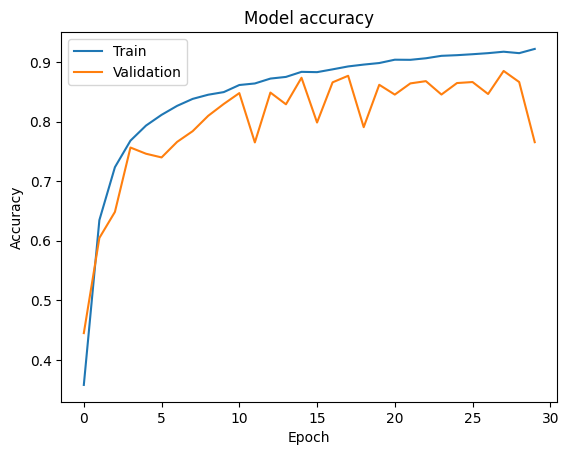

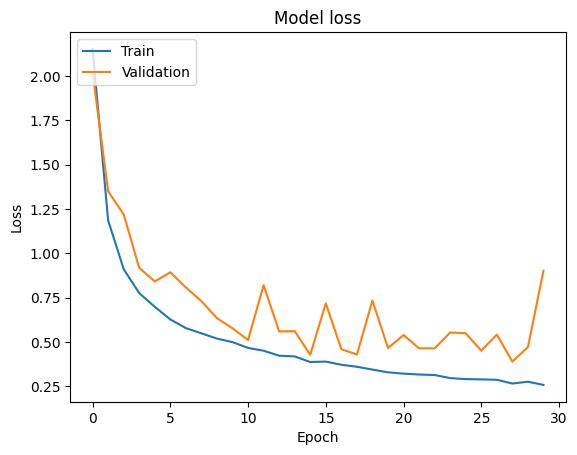

In [ ]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [ ]:
model.load_weights('/content/drive/MyDrive/Thesis/Model/BSL/DenseNet/best_model_densenet_30epcs.h5')
y_pred = model.predict(x_test)
y_pred_labels = np.argmax(y_pred, axis=1)

accuracy = accuracy_score(y_test, y_pred_labels)
print("Accuracy:", accuracy)

# Calculate precision, recall, and F1-score for each class
precision = precision_score(y_test, y_pred_labels, average='macro')
recall = recall_score(y_test, y_pred_labels, average='macro')
f1 = f1_score(y_test, y_pred_labels, average='macro')

print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

208/208 [==============================] - 109s 506ms/step
Accuracy: 0.9082416754557782
Precision: 0.9178821250691417
Recall: 0.9078959059530626
F1 Score: 0.9096236031697629


In [ ]:
# Generate and print the classification report
report = classification_report(y_test, y_pred_labels)
print(report)

              precision    recall  f1-score   support

           0       0.93      0.86      0.89       167
           1       0.89      0.98      0.93       187
           2       0.94      0.96      0.95       180
           3       0.89      0.98      0.93       181
           4       0.97      0.87      0.92       170
           5       0.89      0.95      0.92       171
           6       0.91      0.89      0.90       173
           7       0.97      0.77      0.86       168
           8       0.97      0.93      0.95       187
           9       0.99      0.94      0.97       177
          10       0.91      0.83      0.87       191
          11       0.93      0.84      0.88       176
          12       0.99      0.91      0.95       193
          13       0.86      0.96      0.91       184
          14       1.00      0.84      0.91       159
          15       0.83      0.67      0.74       165
          16       0.83      0.73      0.78       166
          17       0.88    

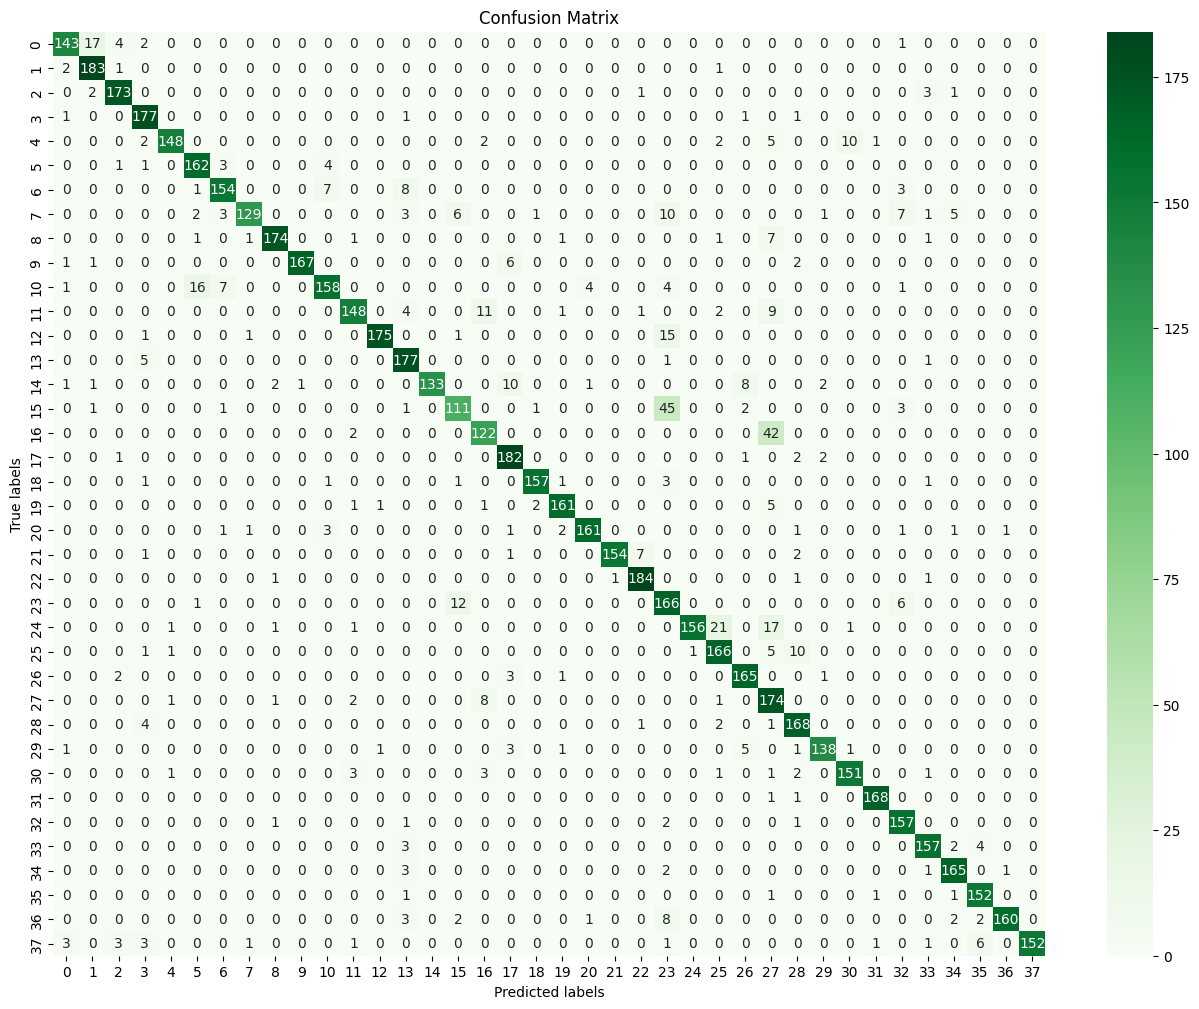

In [ ]:
conf_matrix = confusion_matrix(y_test, y_pred_labels)

# Plot confusion matrix
plt.figure(figsize=(16, 12))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Greens')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

1/1 [==============================] - 0s 77ms/step


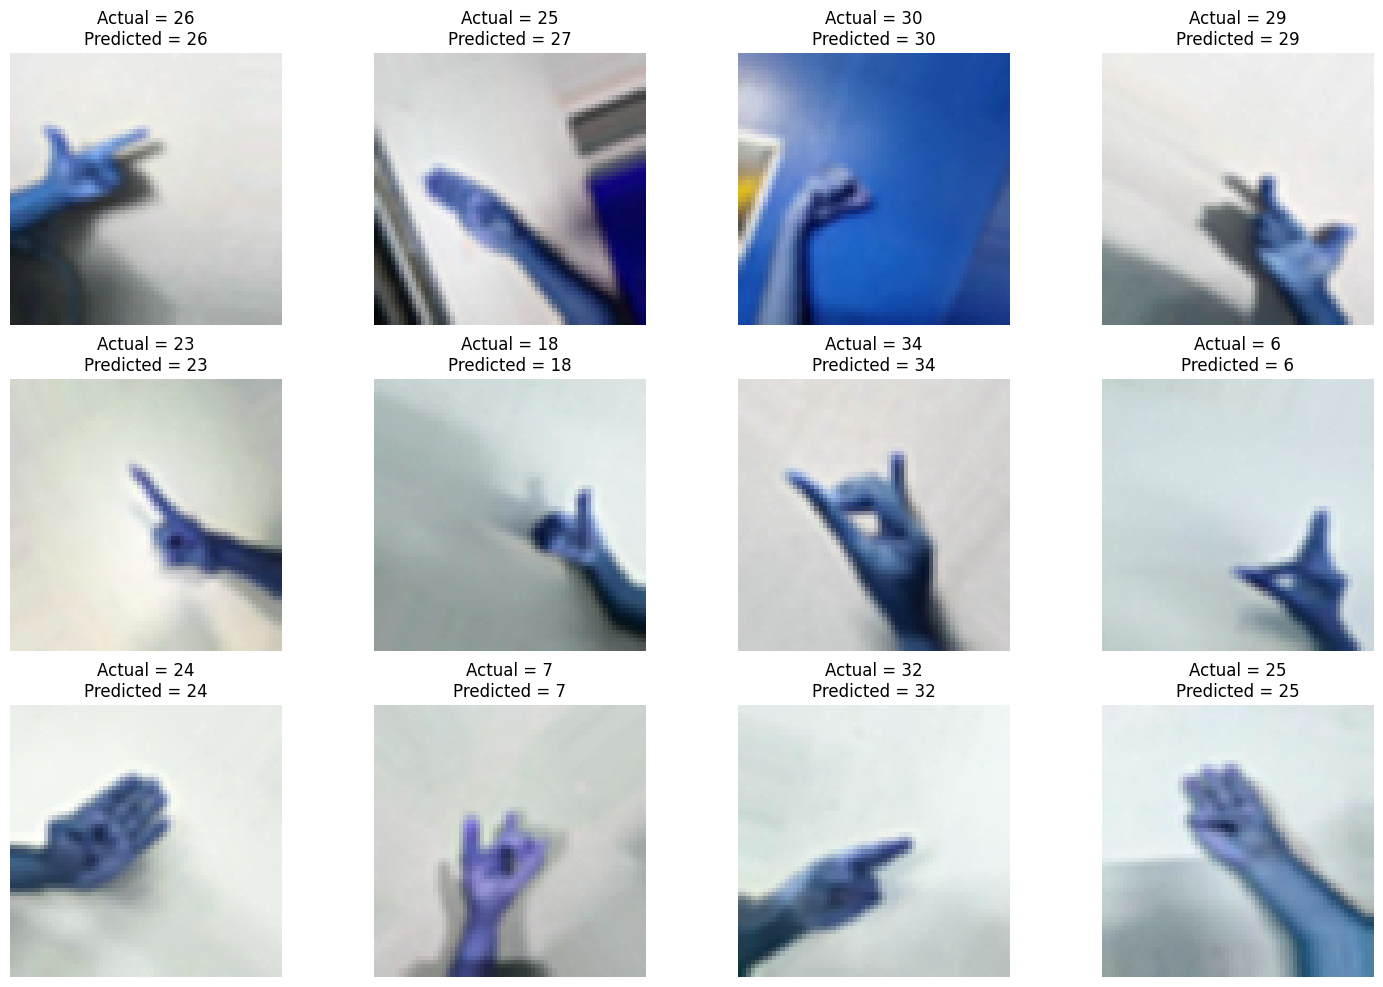

In [ ]:
import random


# Select 12 random indices from x_test
random_indices = random.sample(range(len(x_test)), 12)

plt.figure(figsize=(18, 12))
j = 1
for i in random_indices:
    plt.subplot(3, 4, j)
    j += 1
    plt.imshow(x_test[i], cmap='Greys')

    # Convert one-hot encoded y_test to integer label
    actual_label = (y_test[i])
    predicted_label = np.argmax(model.predict(x_test[i].reshape(1, *x_test[i].shape)))

    # Display only actual and predicted values
    plt.title('Actual = {}\nPredicted = {}'.format(actual_label, predicted_label))
    plt.axis(False)

plt.show()


In [ ]:
model.save('/content/drive/MyDrive/Thesis/Model/BSL/DenseNet/best_model_densenet_30epcs_90_acc.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
from keras.models import load_model
model = load_model('/content/drive/MyDrive/Model/BSL/DenseNet/best_model_densenet_30epcs_90_acc.h5')

y_pred = model.predict(x_test)
y_pred_labels = np.argmax(y_pred, axis=1)

accuracy = accuracy_score(y_test, y_pred_labels)
print("Accuracy:", accuracy)

# Calculate precision, recall, and F1-score for each class
precision = precision_score(y_test, y_pred_labels, average='macro')
recall = recall_score(y_test, y_pred_labels, average='macro')
f1 = f1_score(y_test, y_pred_labels, average='macro')

print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

208/208 [==============================] - 5s 14ms/step
Accuracy: 0.8850384209733313
Precision: 0.8944777400723882
Recall: 0.8852272305382625
F1 Score: 0.8859815151525755


In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint
# checkpoint = ModelCheckpoint('/content/drive/MyDrive/BdSL/best_model_resNEt50.h5', monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)
checkpoint = tf.keras.callbacks.ModelCheckpoint('/content/drive/MyDrive/Model/BSL/DenseNet/best_model_densenet_70epcs_92_acc.h5',
                                                    monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=True)
history = model.fit(
    datagen.flow(x_train, y_train_encoded, batch_size=64),
    # x_train,y_train_encoded,batch_size=64,
    # validation_data=(x_test, y_train_encoded),
    # validation_split =  0.1,
    validation_data=(x_test, y_test_encoded),
    epochs=50,
    callbacks=[checkpoint]

)

Epoch 1/50
415/415 [==============================] - ETA: 0s - loss: 0.2810 - accuracy: 0.9164
Epoch 1: val_loss improved from inf to 0.73455, saving model to /content/drive/MyDrive/Model/BSL/DenseNet/best_model_densenet_30epcs_90_acc.h5
415/415 [==============================] - 107s 194ms/step - loss: 0.2810 - accuracy: 0.9164 - val_loss: 0.7345 - val_accuracy: 0.8153
Epoch 2/50
415/415 [==============================] - ETA: 0s - loss: 0.2741 - accuracy: 0.9175
Epoch 2: val_loss improved from 0.73455 to 0.38964, saving model to /content/drive/MyDrive/Model/BSL/DenseNet/best_model_densenet_30epcs_90_acc.h5
415/415 [==============================] - 76s 184ms/step - loss: 0.2741 - accuracy: 0.9175 - val_loss: 0.3896 - val_accuracy: 0.8865
Epoch 3/50
415/415 [==============================] - ETA: 0s - loss: 0.2497 - accuracy: 0.9245
Epoch 3: val_loss did not improve from 0.38964
415/415 [==============================] - 72s 174ms/step - loss: 0.2497 - accuracy: 0.9245 - val_loss: 0.

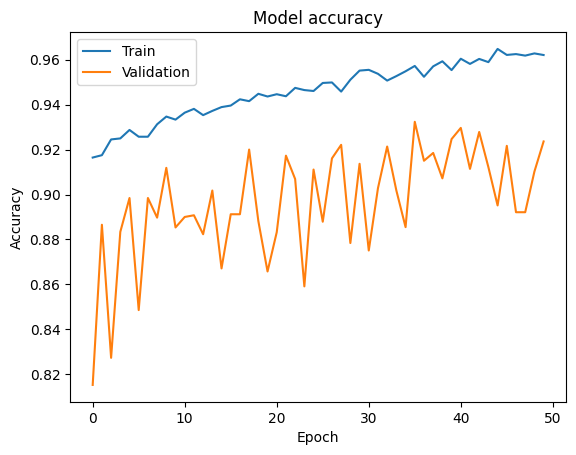

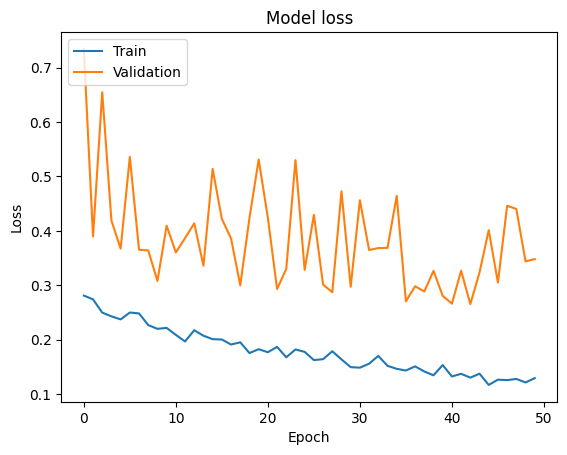

In [ ]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [ ]:
model.load_weights('/content/drive/MyDrive/Model/BSL/DenseNet/best_model_densenet_70epcs_92_acc.h5')
y_pred = model.predict(x_test)
y_pred_labels = np.argmax(y_pred, axis=1)

accuracy = accuracy_score(y_test, y_pred_labels)
print("Accuracy:", accuracy)

  # Calculate precision, recall, and F1-score for each class
precision = precision_score(y_test, y_pred_labels, average='macro')
recall = recall_score(y_test, y_pred_labels, average='macro')
f1 = f1_score(y_test, y_pred_labels, average='macro')

print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

208/208 [==============================] - 3s 15ms/step
Accuracy: 0.9278288383305711
Precision: 0.9298129646897948
Recall: 0.9278042547868276
F1 Score: 0.927952006754876


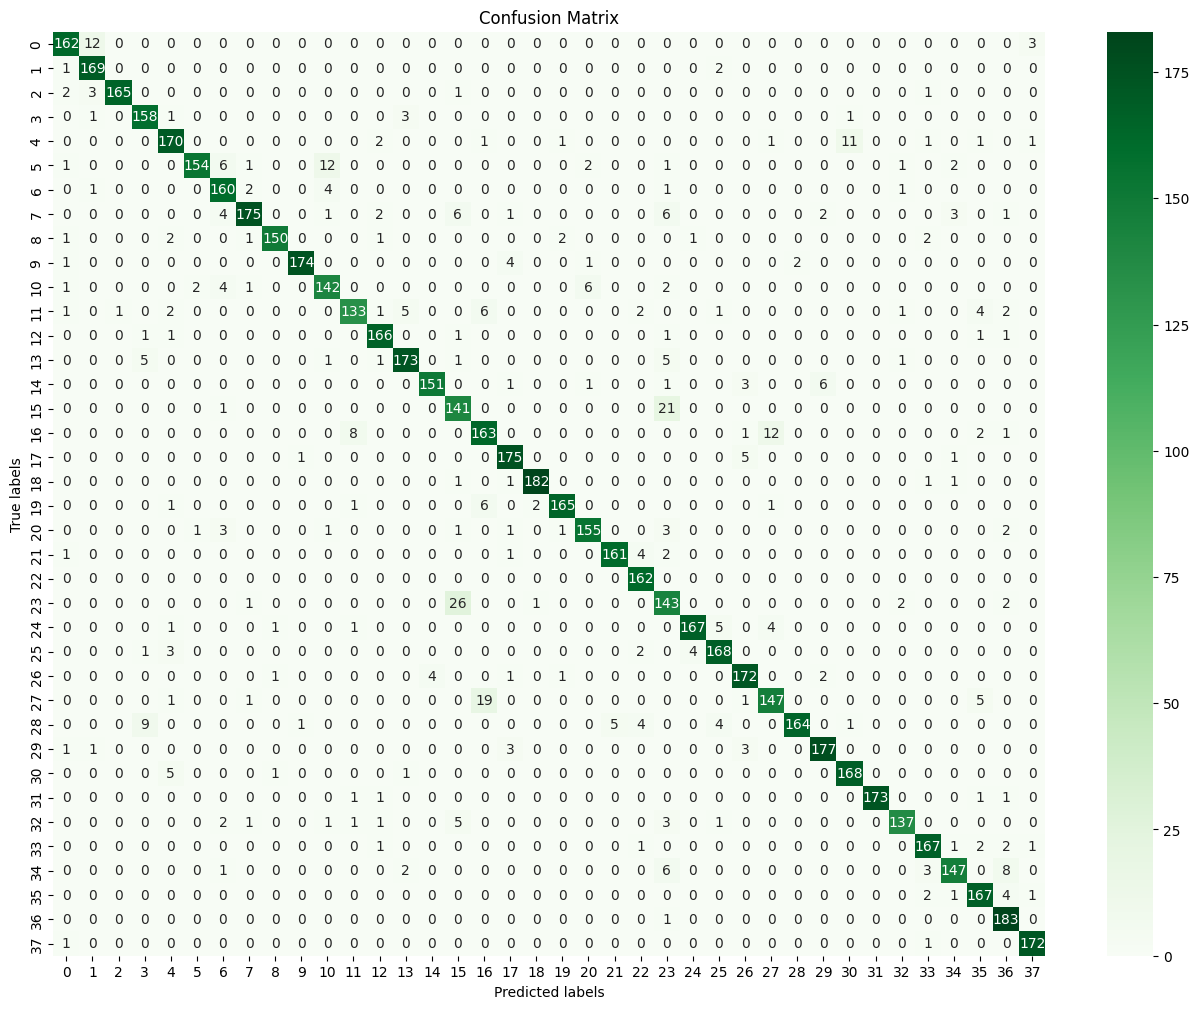

In [ ]:
conf_matrix = confusion_matrix(y_test, y_pred_labels)

# Plot confusion matrix
plt.figure(figsize=(16, 12))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Greens')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

1/1 [==============================] - 0s 41ms/step


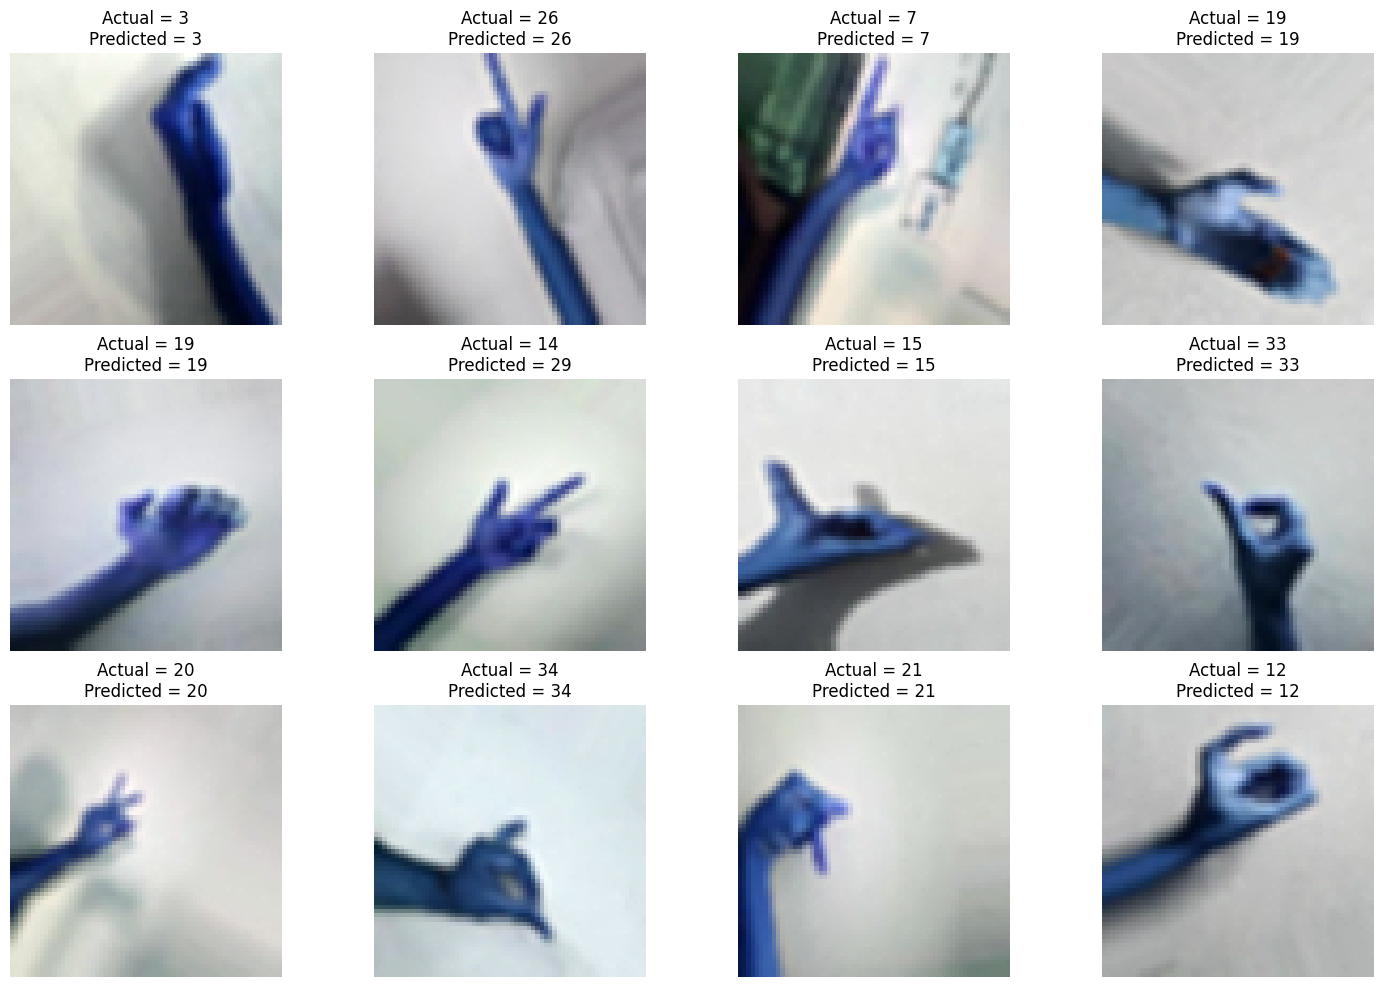

In [ ]:
import random


# Select 12 random indices from x_test
random_indices = random.sample(range(len(x_test)), 12)

plt.figure(figsize=(18, 12))
j = 1
for i in random_indices:
    plt.subplot(3, 4, j)
    j += 1
    plt.imshow(x_test[i], cmap='Greys')

    # Convert one-hot encoded y_test to integer label
    actual_label = (y_test[i])
    predicted_label = np.argmax(model.predict(x_test[i].reshape(1, *x_test[i].shape)))

    # Display only actual and predicted values
    plt.title('Actual = {}\nPredicted = {}'.format(actual_label, predicted_label))
    plt.axis(False)

plt.show()


In [ ]:
model.save('/content/drive/MyDrive/Model/BSL/DenseNet/best_model_densenet_70epcs_92_acc.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
from keras.models import load_model
densenetmodel = load_model('/content/drive/MyDrive/Model/BSL/DenseNet/best_model_densenet_70epcs_92_acc.h5')

y_pred = densenetmodel.predict(x_test)
y_pred_labels = np.argmax(y_pred, axis=1)

accuracy = accuracy_score(y_test, y_pred_labels)
print("Accuracy:", accuracy)

  # Calculate precision, recall, and F1-score for each class
precision = precision_score(y_test, y_pred_labels, average='macro')
recall = recall_score(y_test, y_pred_labels, average='macro')
f1 = f1_score(y_test, y_pred_labels, average='macro')

print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

208/208 [==============================] - 5s 14ms/step
Accuracy: 0.9278288383305711
Precision: 0.9298129646897948
Recall: 0.9278042547868276
F1 Score: 0.927952006754876
